In [81]:
# data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
# data.info()

In [82]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import plotly.express as px 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

In [83]:
from sklearn.impute import SimpleImputer 
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, silhouette_score, accuracy_score, confusion_matrix, mean_squared_error 
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

In [84]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-3-insurance.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [85]:
data.duplicated().sum()
data.drop_duplicates(keep='first',subset=None,ignore_index=False,inplace=True)
data.duplicated().sum()

0

In [86]:
mis_col = data.isna().sum() * 100/len(data)
mis_col.sort_values(ascending=False)
# mis_col

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

In [87]:
orig_reg = data.region 

le = LabelEncoder()

data.region = le.fit_transform(data.region)
data.sex = le.fit_transform(data.sex)
data.smoker = le.fit_transform(data.smoker)

In [88]:
le_reg = data.region 

orireg_dic = np.unique(orig_reg)
lereg_dic = np.unique(le_reg)

reg_dic = dict(zip(orireg_dic,lereg_dic))
reg_dic


{'northeast': 0, 'northwest': 1, 'southeast': 2, 'southwest': 3}

Text(0.5, 1.0, 'Confusion Matrix')

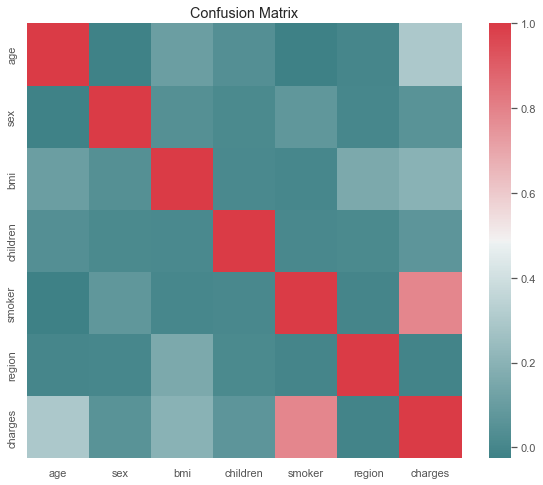

In [89]:
f,ax = plt.subplots(figsize=(10,8))

data_corr = data.corr()

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(200,10, as_cmap=True), ax=ax, square=True)

ax.set_title('Confusion Matrix')

In [90]:
y = data.charges 
x = data.drop(columns=['charges'])


In [91]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x))

y = scaler.fit_transform(np.array(y).reshape(-1,1))
# y

In [92]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=42, test_size=0.3)


In [93]:
ranfor = RandomForestRegressor(criterion='squared_error', n_estimators=100, n_jobs=-1, random_state=42)

ranfor.fit(x_train,y_train)

y_true=y_test
y_pred = ranfor.predict(x_test)
scr_r2 = r2_score(y_true,y_pred)

mod_per = pd.DataFrame( 
    ( 
        'RandomForestRegressor', scr_r2
    )
).transpose()

mod_per.columns = ['Method', 'R2 Test']
mod_per

C:\Users\amunv\AppData\Local\Temp\ipykernel_8420\1973490410.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



,Method,R2 Test
0,RandomForestRegressor,0.862775
